In [9]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

  def __getitem__(self, index):
      if index >= len(self):
          raise IndexError("{} index out of range".format(self.__class__.__name__))

      rng_state = torch.get_rng_state()
      torch.manual_seed(index + self.random_offset)

      while True:
        img = torch.zeros(self.dim, self.dim)
        dx = torch.randint(-10,10,(1,),dtype=torch.float)
        dy = torch.randint(-10,10,(1,),dtype=torch.float)
        c = torch.randint(-20,20,(1,), dtype=torch.float)

        params = torch.cat((dy/dx, c))
        xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
        xy[:,1] = xy[:,0] * params[0] + params[1]

        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < self.dim ]
        xy = xy[ xy[:,0] < self.dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], self.dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          break

      torch.set_rng_state(rng_state)
      return img.unsqueeze(0), params

  def __len__(self):
      return self.size

train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

torch.Size([1, 40, 40])


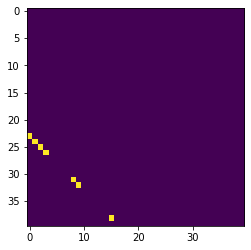

In [10]:
import matplotlib.pyplot as plt 

for i in range(1):
  data, label = train_data.__getitem__(i)
  print(data.shape)

  data = data.squeeze()

  plt.figure()
  plt.imshow(data)
  plt.show()


In [11]:
from torch.utils.data import DataLoader

# load data
trainset = train_data
valset = val_data
testset = test_data

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
valloader = DataLoader(valset, batch_size=128, shuffle=True)

In [12]:
import torch.nn.functional as F
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1, stride=1)
        self.fc1 = nn.Linear(48 * 40 ** 2, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        # input = 128 x 1 x 40 x 40 
        out = self.conv1(x)
        out = F.relu(out)
        # conv1 output = 128 x 48 x 40 x 40 
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [13]:
from torch import optim

nb_epochs = 100
device = "cuda:0"
model = SimpleCNN()
model.to(device)
loss_function = nn.MSELoss(reduction='sum')
optimiser = optim.Adam(model.parameters())

train_losses = []
val_losses = []

for epoch in range(nb_epochs):
    train_loss = 0.0
    model.train()
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device)
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        train_loss += loss.cpu().detach().numpy()
    train_loss = train_loss / (len(trainloader) * 128) 
    train_losses.append(train_loss)

    val_loss = 0.0 
    model.eval()
    for data in valloader:

        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        val_loss += loss.cpu().detach().numpy()
    val_loss = val_loss / (len(valloader) * 128)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()
    
    print("Epoch %d, train_loss %4.2f, val_loss %4.2f" % (epoch, train_loss, val_loss))
print("Finished Training")



Epoch 0, train_loss 111.68, val_loss 84.97
Epoch 1, train_loss 68.78, val_loss 51.39
Epoch 2, train_loss 44.01, val_loss 46.58
Epoch 3, train_loss 37.61, val_loss 45.82
Epoch 4, train_loss 33.25, val_loss 43.02
Epoch 5, train_loss 30.27, val_loss 45.17
Epoch 6, train_loss 27.99, val_loss 42.11
Epoch 7, train_loss 24.70, val_loss 40.49


In [ ]:
plt.figure()
plt.plot(range(nb_epochs), train_losses, label='training')
plt.plot(range(nb_epochs), val_losses, label='validation')
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1, stride=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1, stride=1)
        self.pool = nn.AdaptiveAvgPool2d((48 * 40 ** 2, 1))
        self.fc1 = nn.Linear(48 * 40 ** 2, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        # input = 128 x 1 x 40 x 40 
        out = self.conv1(x)
        out = F.relu(out)
        # conv1 output = 128 x 48 x 40 x 40 
        out = self.conv2(out)
        out = F.relu(out)
        # conv2 output = 128 x 48 x 40 x 40 
        out = self.pool(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

NameError: name 'nn' is not defined

In [ ]:
nb_epochs = 100
device = "cuda:0"
model = BetterCNN()
model.to(device)
loss_function = nn.MSELoss(reduction='sum')
optimiser = optim.Adam(model.parameters())

train_losses = []
val_losses = []

for epoch in range(nb_epochs):
    train_loss = 0.0
    model.train()
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device)
        optimiser.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        train_loss += loss.cpu().detach().numpy()
    train_loss = train_loss / (len(trainloader) * 128) 
    train_losses.append(train_loss)

    val_loss = 0.0 
    model.eval()
    for data in valloader:

        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        val_loss += loss.cpu().detach().numpy()
    val_loss = val_loss / (len(valloader) * 128)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()
    
    print("Epoch %d, train_loss %4.2f, val_loss %4.2f" % (epoch, train_loss, val_loss))
print("Finished Training")